Take Home Assignment 3

3.0 Install any dependencies if needed 


In [1]:
!pip install supervision
!pip install ultralytics


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only


0: 416x640 14 cars, 237.7ms
Speed: 2.7ms preprocess, 237.7ms inference, 11.3ms postprocess per image at shape (1, 3, 416, 640)


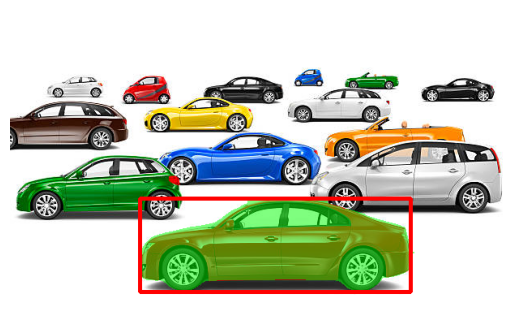


image 1/1 c:\Users\User\Downloads\ETM4272-main\ETM4272-main\demo5_images\canNships.jpeg: 224x224 moving_van 0.78, ambulance 0.09, police_van 0.07, limousine 0.01, garbage_truck 0.01, 20.7ms
Speed: 2.4ms preprocess, 20.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt

# Load the image for segmentation
seg_image = cv2.imread("cars1.jpg")
seg_image = cv2.cvtColor(seg_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plt.imshow

# Load the segmentation model (YOLO11-seg)
seg_model = YOLO('yolo11s-seg.pt')  # Ensure you have the segmentation model

# Load the classification model (YOLO11s-cls)
cls_model = YOLO('yolo11s-cls.pt')

# Run segmentation model on the image
seg_results = seg_model(seg_image)

# Initialize variables to track the largest detected area
max_area = 0
max_index = -1
seg_masks = seg_results[0].masks  # Get masks from the results
seg_boxes = seg_results[0].boxes  # Get bounding boxes

# Iterate through the boxes in the results object 
if seg_masks is not None:
    for idx, (box, mask) in enumerate(zip(seg_boxes, seg_masks.xy)): 
        # For each bounding box, obtain the coordinates and calculate the area
        x1, y1, x2, y2 = box.xyxy[0]  # Get bounding box coordinates
        area = (x2 - x1) * (y2 - y1)  # Compute the area

        if area > max_area:
            max_area = area
            max_index = idx

    if max_index != -1:
        # Get and convert the largest mask coordinates to numpy array
        largest_mask = seg_masks.xy[max_index]  # Get the largest mask coordinates
        largest_mask = np.array(largest_mask, np.int32)  # Convert to numpy array

        # Overlay the mask on the image
        overlay_img = seg_image.copy()
        cv2.fillPoly(overlay_img, [largest_mask], (0, 255, 0))  # Green mask
        alpha = 0.5
        seg_image = cv2.addWeighted(overlay_img, alpha, seg_image, 1 - alpha, 0)

        # Draw a blue bounding box around the largest detected object
        x1, y1, x2, y2 = seg_boxes[max_index].xyxy[0]
        cv2.rectangle(seg_image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)  # Blue box

# Show the segmentation result using plt.imshow
plt.imshow(seg_image)
plt.axis("off")  # Hide axes
plt.show()





3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 90.0ms
Speed: 2.1ms preprocess, 90.0ms inference, 11.7ms postprocess per image at shape (1, 3, 416, 640)


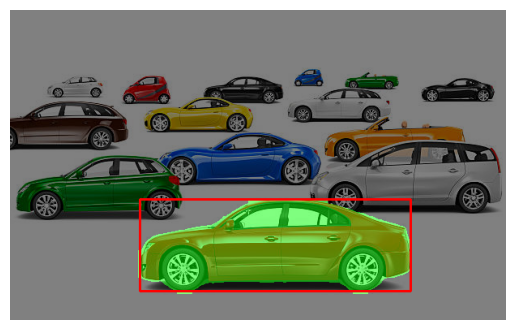

True

In [ ]:

# Load the input image
image_path = "cars1.jpg"
input_image = cv2.imread(image_path)

# Load the YOLO segmentation model
seg_model_path = "yolo11n-seg.pt"
seg_model = YOLO(seg_model_path)

# Run the segmentation model on the input image
seg_results = seg_model(input_image)

# Initialize variables to track the largest detected car's mask and bounding box
max_area = 0
max_mask = None
max_box = None

# Convert YOLO results into a supervision format for further processing
detected_objects = sv.Detections.from_ultralytics(seg_results[0])

# Iterate through the detected objects and find the largest car mask and bounding box
if detected_objects.mask is not None and len(detected_objects.mask) > 0:
    for idx, (box, mask) in enumerate(zip(detected_objects.xyxy, detected_objects.mask)):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        area = width * height
        
        # Check if this is the largest detected object by area
        if area > max_area:
            max_area = area
            max_mask = mask
            max_box = (int(x1), int(y1), int(x2), int(y2))

# If the largest car mask is found, process it
if max_mask is not None:
    # Convert the mask to numpy array and resize to match the input image dimensions
    mask_array = np.array(max_mask, dtype=np.float32)
    mask_array = mask_array.astype(np.uint8)  # Convert to uint8 type
    mask_array = cv2.resize(mask_array, (input_image.shape[1], input_image.shape[0]))  # Resize to input image size
    
    # Create an image where the mask is highlighted in green
    mask_highlighted = np.zeros_like(input_image)
    mask_highlighted[mask_array > 0] = (0, 255, 0)  # Highlight mask in green
    
    # Overlay the mask onto the input image
    input_image = cv2.addWeighted(mask_highlighted, 0.5, input_image, 1 - 0.5, 0)
    
    # Draw the bounding box around the largest detected car
    if max_box is not None:
        x1, y1, x2, y2 = max_box
        cv2.rectangle(input_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Draw a blue bounding box

# Convert BGR to RGB for matplotlib display
output_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.imshow(output_image)
plt.axis("off")  # Hide axes
plt.show()

# Save the result image with the largest car mask overlay
cv2.imwrite("largest_car_mask_output.jpg", input_image)


3.2 Estimate distance to centroid of chair 


0: 384x640 1 chair, 145.3ms
Speed: 2.4ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Estimated depth at chair centroid: 0.0


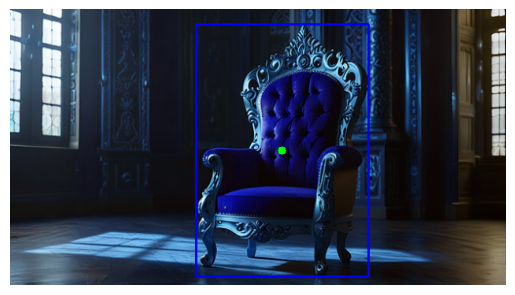

In [ ]:
# Detect the chair in the image  - A detection model of your choice can be used

# Calculate the centroid of the chair - Access box coordinates from the detection model and calculate the centroid

# Obtain the depth map - Depth Anything V2 can be used 

# Query the value of the depth map at the centroid's location

import torch  # Importing PyTorch
from depth_anything_v2.dpt import DepthAnythingV2
import torchvision.transforms as transforms
import cv2
from matplotlib import pyplot as plt

# Load the image
img_path = "kingChair.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Error loading image: {img_path}")

# Convert BGR image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ensure image dimensions are multiples of 14
H, W, _ = img_rgb.shape
new_H = (H // 14) * 14  # Round down to the nearest multiple of 14
new_W = (W // 14) * 14  # Round down to the nearest multiple of 14
img_rgb = cv2.resize(img_rgb, (new_W, new_H))

# Load YOLO11 object detection model
detection_model = YOLO("yolo11s.pt")

# Perform object detection
results = detection_model(img_rgb)

# Find the centroid of the detected chair
centroid_x, centroid_y = None, None
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
        label = result.names[int(box.cls[0])]
        if "chair" in label.lower():
            centroid_x = int((x1 + x2) / 2)
            centroid_y = int((y1 + y2) / 2)
            # Draw bounding box
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box
            break
    if centroid_x is not None:
        break

if centroid_x is None or centroid_y is None:
    raise ValueError("No chair detected in the image.")

# Load Depth Anything V2 model for depth estimation
depth_model = DepthAnythingV2()

# Convert image to PyTorch tensor with correct shape
transform = transforms.Compose([transforms.ToTensor()])  # Converts (H, W, C) to (C, H, W)
img_tensor = transform(img_rgb).unsqueeze(0)  # Add batch dimension (1, C, H, W)

# Run depth estimation
with torch.no_grad():
    depth_map = depth_model(img_tensor).squeeze(0).cpu().numpy()  # Convert back to NumPy

# Query depth at the centroid
chair_depth = depth_map[centroid_y, centroid_x]
print(f"Estimated depth at chair centroid: {chair_depth}")

# Draw centroid on the image
cv2.circle(img_rgb, (centroid_x, centroid_y), 5, (0, 255, 0), -1)  # Green dot

# Display the image with bounding box and centroid
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


3.3.1  Draw bounding boxes around the "cars" using supervision. 

In [4]:
!pip install gdown


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: c:\Users\User\Downloads\ETM4272-main\ETM4272-main\vehicles_video.mp4
100%|██████████| 35.3M/35.3M [00:11<00:00, 3.18MB/s]


'vehicles_video.mp4'

In [ ]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
import cv2

# Load YOLO model
model = YOLO("yolo11n.pt")

In [11]:
# Initialize Supervision annotator with bold green border
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.GREEN)

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform inference
    results = model(frame)[0]
    
    # Extract bounding boxes, class IDs, and confidence scores
    detections = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    
    # Create Supervision Detections object
    detections = sv.Detections(xyxy=detections, confidence=confidences, class_id=class_ids)
    
    # Filter detections to only include 'car' class (assuming class_id 2 for cars, check model labels)
    car_class_id = 2
    mask = detections.class_id == car_class_id
    detections = detections[mask]
    
    # Annotate frame with bold green bounding boxes
    frame = box_annotator.annotate(frame, detections)
    
    return frame

# Process video with supervision
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking.mp4",
    callback=callback
)



0: 384x640 3 cars, 1 truck, 114.1ms
Speed: 4.6ms preprocess, 114.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 103.6ms
Speed: 4.1ms preprocess, 103.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 112.7ms
Speed: 4.6ms preprocess, 112.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 110.5ms
Speed: 5.1ms preprocess, 110.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 113.3ms
Speed: 4.8ms preprocess, 113.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 104.9ms
Speed: 3.9ms preprocess, 104.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 87.8ms
Speed: 4.2ms preprocess, 87.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 82.1ms
Speed: 3.9ms preproce

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [22]:
# Initialize Supervision annotator with bold green border
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.GREEN)

# Initialize tracker
tracker = sv.ByteTrack()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform inference
    results = model(frame)[0]
    
    # Extract bounding boxes, class IDs, and confidence scores
    detections = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    
    # Create Supervision Detections object
    detections = sv.Detections(xyxy=detections, confidence=confidences, class_id=class_ids)
    
    # Filter detections to only include 'car' class (assuming class_id 2 for cars, check model labels)
    car_class_id = 2
    mask = detections.class_id == car_class_id
    detections = detections[mask]
    
    # Track detections
    detections = tracker.update_with_detections(detections)
    
    # Prepare labels
    labels = [f"ID: {tracker_id}" for tracker_id in detections.tracker_id]
    
    # Annotate frame with bold green bounding boxes
    frame = box_annotator.annotate(frame, detections)
    
    # Annotate labels separately with bold black text and larger size
    font_scale = 1.0  # Increase the font scale to make the text larger
    font_thickness = 2  # Thickness of the text
    for i, label in enumerate(labels):
        # Coordinates for the label
        x, y = int(detections.xyxy[i][0]), int(detections.xyxy[i][1]) - 10
        
        # Simulate bold text by drawing the text multiple times with slight offsets
        frame = cv2.putText(frame, label, (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Shadow
        frame = cv2.putText(frame, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Bold black
    
    return frame

# Process video with supervision
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking_id.mp4",
    callback=callback
)



0: 384x640 3 cars, 1 truck, 144.8ms
Speed: 5.5ms preprocess, 144.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 142.2ms
Speed: 5.0ms preprocess, 142.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 152.2ms
Speed: 3.9ms preprocess, 152.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 137.5ms
Speed: 3.9ms preprocess, 137.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 88.3ms
Speed: 3.3ms preprocess, 88.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 135.2ms
Speed: 4.9ms preprocess, 135.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 84.9ms
Speed: 3.4ms preprocess, 84.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 101.9ms
Speed: 4.8ms preproces

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [23]:
# Initialize Supervision annotator with bold green border
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.GREEN)

# Initialize tracker
tracker = sv.ByteTrack()

# To keep track of positions over time
track_history = {}

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform inference
    results = model(frame)[0]
    
    # Extract bounding boxes, class IDs, and confidence scores
    detections = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    
    # Create Supervision Detections object
    detections = sv.Detections(xyxy=detections, confidence=confidences, class_id=class_ids)
    
    # Filter detections to only include 'car' class (assuming class_id 2 for cars, check model labels)
    car_class_id = 2
    mask = detections.class_id == car_class_id
    detections = detections[mask]
    
    # Track detections
    detections = tracker.update_with_detections(detections)
    
    # Prepare labels
    labels = [f"ID: {tracker_id}" for tracker_id in detections.tracker_id]
    
    # Annotate frame with bold green bounding boxes
    frame = box_annotator.annotate(frame, detections)
    
    # Annotate labels separately with bold black text and larger size
    font_scale = 1.0  # Increase the font scale to make the text larger
    font_thickness = 2  # Thickness of the text
    for i, label in enumerate(labels):
        # Coordinates for the label
        x, y = int(detections.xyxy[i][0]), int(detections.xyxy[i][1]) - 10
        
        # Simulate bold text by drawing the text multiple times with slight offsets
        frame = cv2.putText(frame, label, (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Shadow
        frame = cv2.putText(frame, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Bold black
    
    # Draw track traces (paths) for the tracked cars
    for i, tracker_id in enumerate(detections.tracker_id):
        car_id = int(tracker_id)
        
        # Get current car position
        car_position = (int(detections.xyxy[i][0] + (detections.xyxy[i][2] - detections.xyxy[i][0]) / 2),
                        int(detections.xyxy[i][1] + (detections.xyxy[i][3] - detections.xyxy[i][1]) / 2))  # Center of the bounding box
        
        # If the tracker_id has been seen before, add the position to its history
        if car_id not in track_history:
            track_history[car_id] = []
        track_history[car_id].append(car_position)
        
        # Draw the track trace (path) for the car
        if len(track_history[car_id]) > 1:
            # Draw the path by connecting points
            for j in range(1, len(track_history[car_id])):
                cv2.line(frame, track_history[car_id][j-1], track_history[car_id][j], (0, 0, 255), 2)  # Green trace
    
    return frame

# Process video with supervision
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking_with_trace.mp4",
    callback=callback
)



0: 384x640 3 cars, 1 truck, 111.5ms
Speed: 3.9ms preprocess, 111.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 166.7ms
Speed: 5.5ms preprocess, 166.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 124.0ms
Speed: 5.9ms preprocess, 124.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 149.6ms
Speed: 5.2ms preprocess, 149.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 127.2ms
Speed: 4.4ms preprocess, 127.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 132.7ms
Speed: 5.1ms preprocess, 132.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 94.2ms
Speed: 3.6ms preprocess, 94.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 93.0ms
Speed: 4.7ms preproce

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does. 

Answers: Callback Function in Real-Time Video Processing
In computer vision, a callback function processes video frames in real time, making it essential for object detection and tracking. The function callback(frame: np.ndarray, _: int) -> np.ndarray continuously receives frames, modifies them, and returns them for further processing, commonly used in video analysis and object tracking.

Function Purpose
The callback function is triggered for each frame, detecting and tracking cars by assigning unique IDs and drawing bounding boxes and track traces. This ensures seamless tracking as objects appear and disappear across frames.

Parameters & Return Type
The function takes frame, a NumPy array representing an image, and _, an unused frame index placeholder. It returns a modified frame with bounding boxes and traces, preserving the original video structure.

Object Detection with YOLO
The function detects objects using model(frame)[0], extracting bounding boxes, class labels, and confidence scores. It then filters out non-car objects, keeping only class ID 2 (cars) for precise tracking.

Tracking Cars with Unique IDs
Using tracker.update_with_detections(detections), the function assigns unique IDs to cars, ensuring consistent tracking across frames, even as vehicles move.

Annotating & Visualizing Tracking
Bounding boxes are drawn using box_annotator.annotate(frame, detections), highlighting detected cars. The function calculates car center points to track movement and connects past positions with red lines using cv2.line(), creating a motion path.

Labeling & Returning Processed Frames
Each car is labeled with its tracking ID using cv2.putText(), ensuring clarity. The processed frame, containing bounding boxes, track traces, and IDs, is returned for display or saving.

Practical Applications
This function is valuable for traffic monitoring, autonomous driving, and security surveillance. It enables real-time vehicle tracking, movement analysis, and pattern detection, making it a crucial tool for video analysis applications.